# Advanced Data Mining Project

## Topic of the project: Dogs & Cats image classification

## Author: Szymon Lepianka

The main goal of the project is to build a neural network model that would be able to classify whether a given photo shows a dog or a cat, based on their image. Dataset used comes from kaggle.com:

[Kaggle](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset)

and contains 25,000 images of dogs and cats. This can be best utilized in a binary classification problem set in computer vision.

## Import necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import (confusion_matrix, classification_report)
from sklearn import metrics
import itertools
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.callbacks import EarlyStopping
from keras import backend as K
K.clear_session()
from sklearn.utils import shuffle

## Kaggle setup

In [2]:
import json
!pip install kaggle
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json

api_token = {"username":"szymonlepianka","key":"486fdb332439db4439ff19ecc397b6ea"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
! mkdir input
! 7z x microsoft-catsvsdogs-dataset.zip -oinput -aoa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 782M/788M [00:04<00:00, 233MB/s]
100% 788M/788M [00:04<00:00, 167MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 825979578 bytes (788 MiB)

Extracting archive: microsoft-catsvsdogs-dataset.zip
 16% 4096 Open              --
Path = microsoft-catsvsdogs-dataset.zip
Type = zip
Physical Size = 825979578

  0%      2% 518 - PetImages/Cat/10462.jpg                                    3% 873 - PetImages/Cat/10782.jpg                                    4% 1208 - PetImages/Cat/11083.jpg

## Data overview

In [3]:
# Number of images in dataset

set_dogs_dir = './input/PetImages/Dog/'
set_cats_dir = './input/PetImages/Cat/'

no_of_images_dog = len(os.listdir(set_dogs_dir))
no_of_images_cat = len(os.listdir(set_cats_dir))

print('Number of dogs images: ' + str(no_of_images_dog))
print('Number of cats images: ' + str(no_of_images_cat))
print('Total number of images: ' + str(no_of_images_dog + no_of_images_cat))

Number of dogs images: 12501
Number of cats images: 12501
Total number of images: 25002


In [4]:
# moving photos of dogs and cats to one folder

set_all_dir = './input/PetImages/all/'

if not os.path.exists(set_all_dir):
    os.makedirs(set_all_dir) 
    for file in os.listdir(set_cats_dir):
      if file.endswith(".jpg") and file != "666.jpg": # this image file is empty
        shutil.copy(set_cats_dir + file, set_all_dir + 'cat.' + file)
    for file in os.listdir(set_dogs_dir):
      if file.endswith(".jpg") and file != "11702.jpg": # this image file is empty
        shutil.copy(set_dogs_dir + file, set_all_dir + 'dog.' + file)


no_of_images_all = len(os.listdir(set_all_dir))
print('Total number of images: ' + str(no_of_images_all))

Total number of images: 24998


## Preparation of data

In [5]:
# image names and labels
x_imgname = [file for file in os.listdir(set_all_dir)]
y_label = [file.split('.')[0] for file in os.listdir(set_all_dir)]

# creation of dataframe with all images
image_df = pd.DataFrame({'filename': x_imgname, 'category': y_label})
print(image_df.head(5))

       filename category
0  dog.7326.jpg      dog
1  dog.3728.jpg      dog
2  cat.4470.jpg      cat
3  cat.9505.jpg      cat
4  dog.1404.jpg      dog


## Data visualization

In [6]:
def showImages(data, categ):
    cat_df, dog_df = data[data['category'] == 'cat'], data[data['category'] == 'dog']
    if categ == 'dog':
        X, Y  = dog_df['img_paths'], dog_df['ID']
    elif categ == 'cat':
        X, Y  = cat_df['img_paths'], cat_df['ID']     
    else:
        X, Y  = data['img_paths'], data['ID']

    (X_rand, Y_rand) = shuffle(X, Y)
    
    fig, ax = plt.subplots(5, 5, figsize = (12,12), dpi = 100)
    for i in range(0,5):
      for j in range(0,5):
        image = load_img(X_rand.iloc[i * 5 + j], target_size=(125, 125))
        ax[i, j].imshow(image)
        ax[i, j].set_title("{}".format(Y_rand.iloc[i * 5 + j]))
        ax[i, j].axis('off')
        del image

In [7]:
# extracting image ids, category and paths from directory
img_paths = [] # list of image paths
categories = [] # list of categories
ID = [] # list of image ids
for file in os.listdir(set_all_dir):
    path = os.path.join(set_all_dir, file)
    img_paths.append(path)
    categories.append(file.split('.')[0])
    ID.append(file.split('.')[1])

#creating new dataframe for visualization
df_for_visualization = pd.DataFrame({'ID': ID, 'category': categories, 'img_paths': img_paths})

print(df_for_visualization.head(5))

     ID category                           img_paths
0  7326      dog  ./input/PetImages/all/dog.7326.jpg
1  3728      dog  ./input/PetImages/all/dog.3728.jpg
2  4470      cat  ./input/PetImages/all/cat.4470.jpg
3  9505      cat  ./input/PetImages/all/cat.9505.jpg
4  1404      dog  ./input/PetImages/all/dog.1404.jpg


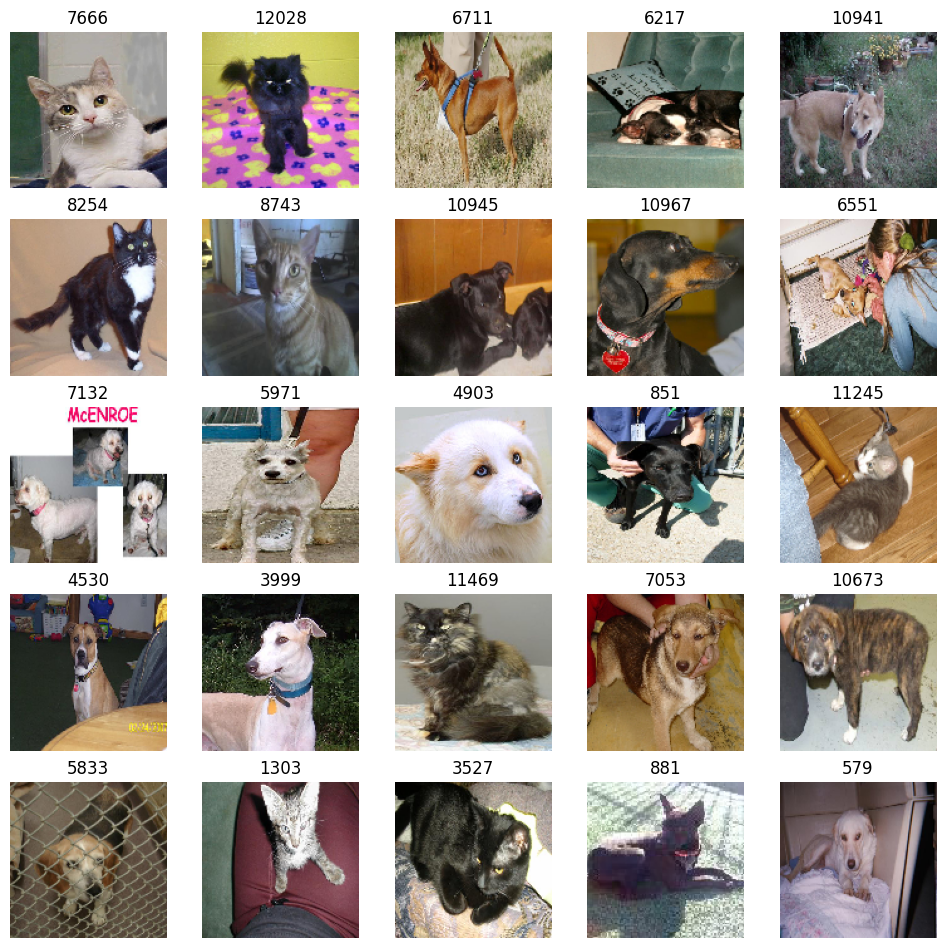

In [8]:
# showImages(df_for_visualization, categ = 'dog')
# showImages(df_for_visualization, categ = 'cat')
showImages(df_for_visualization, categ = 'both')

## Train test split

In [9]:
# Data split into train, validation and test data
train_valid_df, test_df = train_test_split(image_df, test_size = 0.08)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2)

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
test_images = test_df.shape[0]

print('Number of training images: ' + str(train_images))
print('Number of validating images: ' + str(valid_images))
print('Number of testing images: ' + str(test_images))

Number of training images: 18398
Number of validating images: 4600
Number of testing images: 2000


### Data distribution

In [10]:
print("Training data:")
print("\tDog:", len(train_df[train_df['category'] == 'dog']))
print("\tCat:", len(train_df[train_df['category'] == 'cat']))

print("Validation data:")
print("\tDog:", len(valid_df[valid_df['category'] == 'dog']))
print("\tCat:", len(valid_df[valid_df['category'] == 'cat']))

print("Test data:")
print("\tDog:", len(test_df[test_df['category'] == 'dog']))
print("\tCat:", len(test_df[test_df['category'] == 'cat']))


Training data:
	Dog: 9204
	Cat: 9194
Validation data:
	Dog: 2284
	Cat: 2316
Test data:
	Dog: 1011
	Cat: 989


## ImageDataGenerator

In [11]:
img_size = 100
batch_size = 64

# dataframe iterators
train_generator = ImageDataGenerator()
valid_generator = ImageDataGenerator()
test_generator =  ImageDataGenerator()
        
train_data = train_generator.flow_from_dataframe(
    train_df,
    set_all_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical')

valid_data = valid_generator.flow_from_dataframe(
    valid_df, 
    set_all_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical')


test_data = test_generator.flow_from_dataframe(
    test_df, 
    set_all_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

Found 18398 validated image filenames belonging to 2 classes.
Found 4600 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


## Model 0

In [102]:
model0 = Sequential()
model0.add(Conv2D(16, (3,3), activation = 'relu', input_shape = (img_size, img_size, 3)))
model0.add(Conv2D(16, (3,3), activation = 'relu'))
model0.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model0.add(Conv2D(32, (3,3), activation = 'relu'))
model0.add(Conv2D(32, (3,3), activation = 'relu'))
model0.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model0.add(Conv2D(64, (3,3), activation = 'relu'))
model0.add(Conv2D(64, (3,3), activation = 'relu'))
model0.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model0.add(Conv2D(128, (3,3), activation = 'relu'))
model0.add(Conv2D(128, (3,3), activation = 'relu'))
model0.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model0.add(Dropout(0.3))

model0.add(Flatten())

model0.add(Dense(512, activation = 'relu'))

model0.add(Dropout(0.5))

model0.add(Dense(2, activation = 'softmax'))

model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                  

In [103]:
#compiling model
model0.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [early_stopping]
epochs = 100

model0_history = model0.fit(train_data, 
                            epochs=epochs,
                            validation_data=valid_data,
                            validation_steps=valid_images//batch_size,
                            steps_per_epoch=train_images//batch_size,
                            callbacks=callbacks)

Epoch 1/100
177/287 [=================>............] - ETA: 17s - loss: 0.7385 - accuracy: 0.5425

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

287/287 [==============================] - 59s 204ms/step - loss: 0.7030 - accuracy: 0.5721 - val_loss: 0.6303 - val_accuracy: 0.6367
Epoch 2/100
287/287 [==============================] - 58s 201ms/step - loss: 0.5857 - accuracy: 0.6865 - val_loss: 0.5420 - val_accuracy: 0.7181
Epoch 3/100
287/287 [==============================] - 58s 203ms/step - loss: 0.4895 - accuracy: 0.7666 - val_loss: 0.4328 - val_accuracy: 0.8107
Epoch 4/100
287/287 [==============================] - 58s 200ms/step - loss: 0.4317 - accuracy: 0.8020 - val_loss: 0.4110 - val_accuracy: 0.8134
Epoch 5/100
287/287 [==============================] - 57s 200ms/step - loss: 0.3710 - accuracy: 0.8360 - val_loss: 0.3407 - val_accuracy: 0.8479
Epoch 6/100
287/287 [==============================] - 57s 200ms/step - loss: 0.3280 - accuracy: 0.8622 - val_loss: 0.3440 - val_accuracy: 0.8504
Epoch 7/100
287/287 [==============================] - 57s 200ms/step - loss: 0.2961 - accuracy: 0.8724 - val_loss: 0.3108 - val_accurac

In [15]:
def plot_learning_curve(model_history):

  # accuracy
  plt.plot(model_history.history['accuracy'], label='accuracy')
  plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.show()

  # loss
  plt.plot(model_history.history['loss'], label='loss')
  plt.plot(model_history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

def plot_confusion_matrix(y_true, y_pred, test_data):

  # Compute the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix
  plt.imshow(conf_matrix, cmap=plt.cm.Blues)

  # Add labels to the plot
  class_names = test_data.class_indices.keys()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Add a colorbar
  plt.colorbar()

  # Add values to the plot
  for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
      plt.text(j, i, conf_matrix[i, j],
              horizontalalignment="center",
              color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

  # Add labels to the plot
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion matrix')

  # Show the plot
  plt.show()

def plot_classification_report(y_true, y_pred):
  target_names = ['Cat', 'Dog']
  print(classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names))

def plot_2_misclassified_objects(y_pred, y_true, test_data):
  # Create a boolean mask to filter out the misclassified objects:
  misclassified_mask = (y_pred != y_true)

  # Get the indices of the misclassified images
  misclassified_indices = np.where(misclassified_mask)[0]

  # Get the file paths of the misclassified objects:
  misclassified_file_paths = [test_data.filepaths[i] for i in misclassified_indices]

  # Select the first two misclassified images
  first_misclassified_image = plt.imread(misclassified_file_paths[0])
  second_misclassified_image = plt.imread(misclassified_file_paths[1])

  # Plot the first misclassified image
  plt.imshow(first_misclassified_image)
  plt.title("True label: " + list(test_data.class_indices.keys())[list(test_data.class_indices.values()).index(y_true[misclassified_indices[0]])] + ", Predicted label: " + list(test_data.class_indices.keys())[list(test_data.class_indices.values()).index(y_pred[misclassified_indices[0]])])
  plt.show()

  # Plot the second misclassified image
  plt.imshow(second_misclassified_image)
  plt.title("True label: " + list(test_data.class_indices.keys())[list(test_data.class_indices.values()).index(y_true[misclassified_indices[1]])] + ", Predicted label: " + list(test_data.class_indices.keys())[list(test_data.class_indices.values()).index(y_pred[misclassified_indices[1]])])
  plt.show()

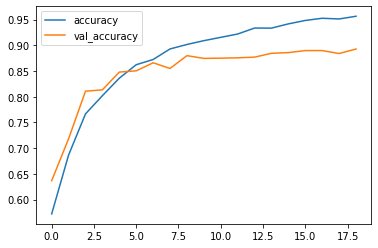

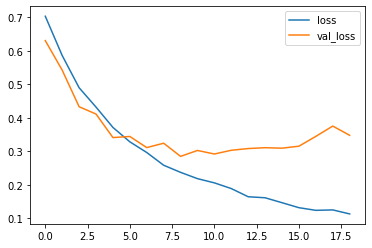

In [104]:
plot_learning_curve(model0_history)

In [105]:
loss, acc = model0.evaluate(test_data)
print("Accuracy", acc)

32/32 [==============================] - 5s 159ms/step - loss: 0.3779 - accuracy: 0.8785
Accuracy 0.8784999847412109


In [106]:
probs = model0.predict(test_data)
y_pred = np.argmax(probs, axis=1)
y_true = test_data.classes

32/32 [==============================] - 5s 158ms/step


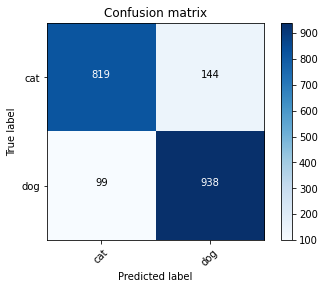

In [107]:
plot_confusion_matrix(y_true, y_pred, test_data)

In [108]:
plot_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

         Cat       0.89      0.85      0.87       963
         Dog       0.87      0.90      0.89      1037

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



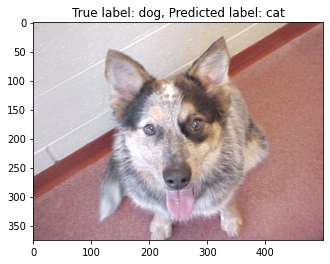

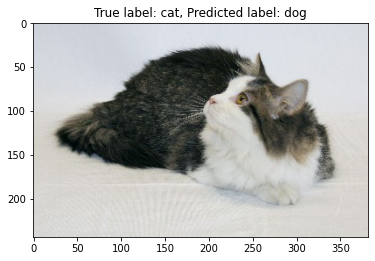

In [109]:
plot_2_misclassified_objects(y_pred, y_true, test_data)

## Model 2

In [56]:
resNet = tf.keras.applications.ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3))

resNet.trainable = False # Freeze layers
resNet_model = Sequential([
    resNet,
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(0.4),
    Dense(2, activation = 'softmax')])

resNet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              33555456  
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 57,145,218
Trainable params: 33,557,506
Non-trainable params: 23,587,712
__________________________________

In [57]:
resNet_model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [early_stopping]
epoch = 15

resNet_model_history = resNet_model.fit(train_data, epochs = epoch,
                          validation_data = valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size,
                          callbacks = callbacks)

Epoch 1/15
113/299 [==========>...................] - ETA: 29s - loss: 4.2372 - accuracy: 0.8380

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

299/299 [==============================] - 64s 204ms/step - loss: 1.7569 - accuracy: 0.8734 - val_loss: 0.2227 - val_accuracy: 0.9021
Epoch 2/15
299/299 [==============================] - 60s 202ms/step - loss: 0.2109 - accuracy: 0.9127 - val_loss: 0.2115 - val_accuracy: 0.9090
Epoch 3/15
299/299 [==============================] - 60s 201ms/step - loss: 0.1767 - accuracy: 0.9275 - val_loss: 0.2179 - val_accuracy: 0.9119
Epoch 4/15
299/299 [==============================] - 60s 201ms/step - loss: 0.1481 - accuracy: 0.9398 - val_loss: 0.2341 - val_accuracy: 0.9127
Epoch 5/15
299/299 [==============================] - 60s 201ms/step - loss: 0.1273 - accuracy: 0.9477 - val_loss: 0.2382 - val_accuracy: 0.9094
Epoch 6/15
299/299 [==============================] - 60s 202ms/step - loss: 0.1122 - accuracy: 0.9539 - val_loss: 0.2811 - val_accuracy: 0.9119
Epoch 7/15
299/299 [==============================] - 61s 204ms/step - loss: 0.1005 - accuracy: 0.9587 - val_loss: 0.2883 - val_accuracy: 0.9

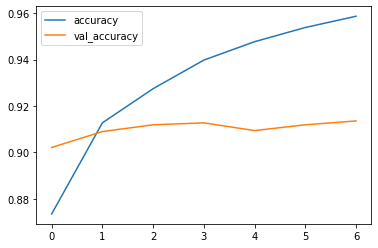

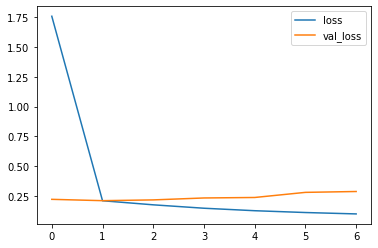

16/16 [==============================] - 3s 170ms/step - loss: 0.2604 - accuracy: 0.9120
Accuracy 0.9120000004768372
16/16 [==============================] - 3s 160ms/step


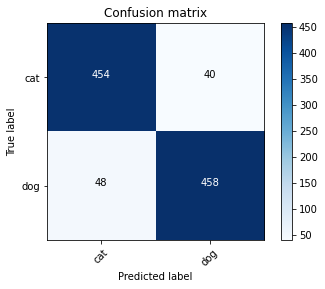

              precision    recall  f1-score   support

         Cat       0.90      0.92      0.91       494
         Dog       0.92      0.91      0.91       506

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



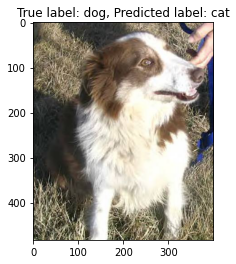

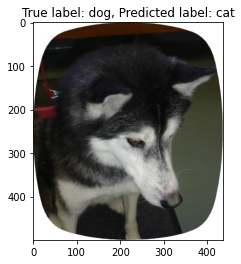

In [62]:
plot_learning_curve(resNet_model_history)

loss, acc = resNet_model.evaluate(test_data)
print("Accuracy", acc)

probs = resNet_model.predict(test_data)
y_pred = np.argmax(probs,axis=1)
y_true = test_data.classes

plot_confusion_matrix(y_true, y_pred, test_data)

plot_classification_report(y_true, y_pred)

plot_2_misclassified_objects(y_pred, y_true, test_data)

## Model 3

In [59]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', 
                  input_shape=(img_size, img_size, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='softmax'))

model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (None, 98, 98, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 47, 47, 64)      

In [60]:
model3.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [early_stopping]
epoch = 50

model3_history = model3.fit(train_data, epochs = epoch,
                          validation_data = valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size,
                          callbacks = callbacks)

Epoch 1/50
299/299 [==============================] - 62s 203ms/step - loss: 0.7808 - accuracy: 0.6485 - val_loss: 0.5873 - val_accuracy: 0.6875
Epoch 2/50
299/299 [==============================] - 60s 201ms/step - loss: 0.5298 - accuracy: 0.7414 - val_loss: 0.6620 - val_accuracy: 0.6767
Epoch 3/50
299/299 [==============================] - 60s 200ms/step - loss: 0.4474 - accuracy: 0.7900 - val_loss: 0.4459 - val_accuracy: 0.7981
Epoch 4/50
299/299 [==============================] - 60s 201ms/step - loss: 0.3976 - accuracy: 0.8188 - val_loss: 0.7742 - val_accuracy: 0.6631
Epoch 5/50
299/299 [==============================] - 60s 202ms/step - loss: 0.3686 - accuracy: 0.8350 - val_loss: 0.7365 - val_accuracy: 0.6954
Epoch 6/50
299/299 [==============================] - 61s 204ms/step - loss: 0.3342 - accuracy: 0.8562 - val_loss: 0.9915 - val_accuracy: 0.6475
Epoch 7/50
299/299 [==============================] - 61s 204ms/step - loss: 0.3175 - accuracy: 0.8616 - val_loss: 0.4998 - val_ac

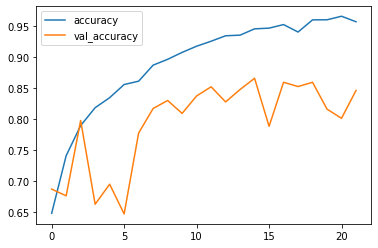

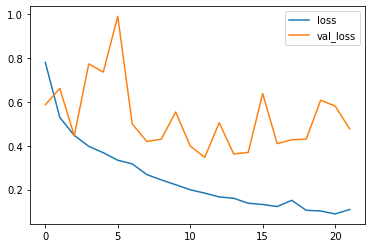

16/16 [==============================] - 3s 161ms/step - loss: 0.4796 - accuracy: 0.8570
Accuracy 0.8569999933242798
16/16 [==============================] - 3s 159ms/step


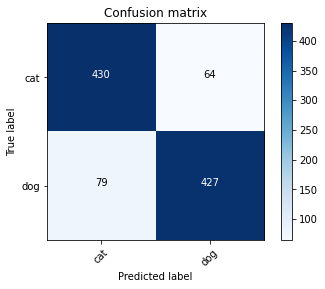

              precision    recall  f1-score   support

         Cat       0.84      0.87      0.86       494
         Dog       0.87      0.84      0.86       506

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



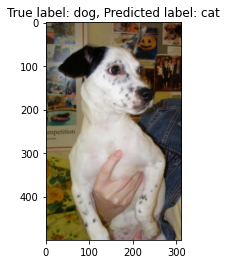

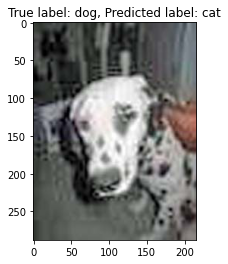

In [63]:
plot_learning_curve(model3_history)

loss, acc = model3.evaluate(test_data)
print("Accuracy", acc)

probs = model3.predict(test_data)
y_pred = np.argmax(probs,axis=1)
y_true = test_data.classes

plot_confusion_matrix(y_true, y_pred, test_data)

plot_classification_report(y_true, y_pred)

plot_2_misclassified_objects(y_pred, y_true, test_data)

## Model 4

In [12]:
model4=Sequential()
model4.add(Conv2D(32, (3,3), activation="relu", 
                  input_shape=(img_size, img_size, 3)))
model4.add(Conv2D(32, (3,3), activation="relu"))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2,2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, (3,3), activation="relu"))
model4.add(Conv2D(64, (3,3), activation="relu"))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(2,2))
model4.add(Dropout(0.25))

model4.add(Conv2D(128, (3,3), activation="relu"))
model4.add(Conv2D(128, (3,3), activation="relu"))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2,2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, (3,3), activation="relu"))
model4.add(Conv2D(64, (3,3), activation="relu"))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2,2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(512, activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(2, activation='softmax'))
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        1

In [13]:
model4.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [early_stopping]
epoch = 50

model4_history = model4.fit(train_data, epochs=epoch,
                          validation_data=valid_data,
                          validation_steps=valid_images//batch_size,
                          steps_per_epoch=train_images//batch_size,
                          callbacks=callbacks)

Epoch 1/50
287/287 [==============================] - 89s 262ms/step - loss: 0.7666 - accuracy: 0.5965 - val_loss: 0.7574 - val_accuracy: 0.5902
Epoch 2/50
287/287 [==============================] - 63s 218ms/step - loss: 0.5550 - accuracy: 0.7232 - val_loss: 0.7783 - val_accuracy: 0.5995
Epoch 3/50
287/287 [==============================] - 63s 220ms/step - loss: 0.4660 - accuracy: 0.7820 - val_loss: 0.5895 - val_accuracy: 0.7060
Epoch 4/50
287/287 [==============================] - 63s 219ms/step - loss: 0.4041 - accuracy: 0.8196 - val_loss: 0.8689 - val_accuracy: 0.6424
Epoch 5/50
287/287 [==============================] - 64s 224ms/step - loss: 0.3550 - accuracy: 0.8463 - val_loss: 0.3625 - val_accuracy: 0.8420
Epoch 6/50
287/287 [==============================] - 63s 219ms/step - loss: 0.3093 - accuracy: 0.8684 - val_loss: 0.3819 - val_accuracy: 0.8363
Epoch 7/50
287/287 [==============================] - 68s 237ms/step - loss: 0.2783 - accuracy: 0.8844 - val_loss: 0.3123 - val_ac

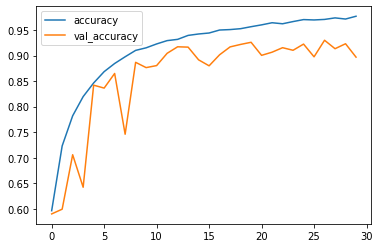

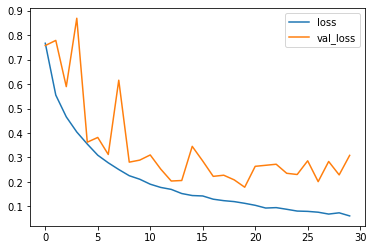

 7/32 [=====>........................] - ETA: 4s - loss: 0.3481 - accuracy: 0.8772

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

32/32 [==============================] - 6s 173ms/step - loss: 0.3374 - accuracy: 0.8940
Accuracy 0.8939999938011169
32/32 [==============================] - 5s 158ms/step


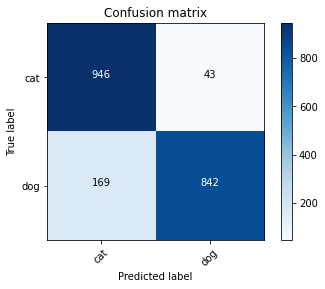

              precision    recall  f1-score   support

         Cat       0.85      0.96      0.90       989
         Dog       0.95      0.83      0.89      1011

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



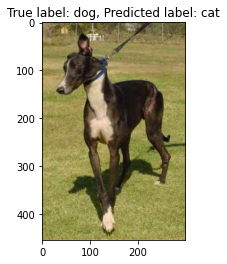

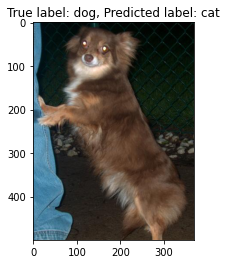

In [16]:
plot_learning_curve(model4_history)

loss, acc = model4.evaluate(test_data)
print("Accuracy", acc)

probs = model4.predict(test_data)
y_pred = np.argmax(probs,axis=1)
y_true = test_data.classes

plot_confusion_matrix(y_true, y_pred, test_data)

plot_classification_report(y_true, y_pred)

plot_2_misclassified_objects(y_pred, y_true, test_data)

## Model 5

In [68]:
base_en_model = EfficientNetB4(weights="imagenet", 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3), 
                               classes=2)

for layer in base_en_model.layers:
        layer.trainable = False

output_model = base_en_model.output
output_model = AveragePooling2D(pool_size=(3,3))(output_model)
output_model = Flatten()(output_model)
output_model = Dense(128, activation="relu")(output_model)
output_model = Dropout(0.4)(output_model)
output_model = Dense(64, activation="relu")(output_model)
output_model = Dense(2, activation="softmax")(output_model)
model5 = Model(inputs=base_en_model.input, outputs=output_model)
model5.summary()

71686520/71686520 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 100, 100, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)

In [69]:
model5.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [early_stopping]
epoch = 15

model5_history = model5.fit(train_data, epochs=epoch,
                          validation_data=valid_data,
                          validation_steps=valid_images//batch_size,
                          steps_per_epoch=train_images//batch_size,
                          callbacks=callbacks)

Epoch 1/15
202/299 [===================>..........] - ETA: 15s - loss: 0.1970 - accuracy: 0.9192

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

299/299 [==============================] - 75s 212ms/step - loss: 0.1859 - accuracy: 0.9239 - val_loss: 0.1497 - val_accuracy: 0.9373
Epoch 2/15
299/299 [==============================] - 60s 202ms/step - loss: 0.1501 - accuracy: 0.9401 - val_loss: 0.1455 - val_accuracy: 0.9385
Epoch 3/15
299/299 [==============================] - 61s 203ms/step - loss: 0.1329 - accuracy: 0.9463 - val_loss: 0.1439 - val_accuracy: 0.9425
Epoch 4/15
299/299 [==============================] - 60s 202ms/step - loss: 0.1209 - accuracy: 0.9512 - val_loss: 0.1497 - val_accuracy: 0.9404
Epoch 5/15
299/299 [==============================] - 60s 202ms/step - loss: 0.1127 - accuracy: 0.9546 - val_loss: 0.1545 - val_accuracy: 0.9388
Epoch 6/15
299/299 [==============================] - 60s 202ms/step - loss: 0.1032 - accuracy: 0.9581 - val_loss: 0.1510 - val_accuracy: 0.9406
Epoch 7/15
299/299 [==============================] - 61s 205ms/step - loss: 0.0968 - accuracy: 0.9616 - val_loss: 0.1515 - val_accuracy: 0.9

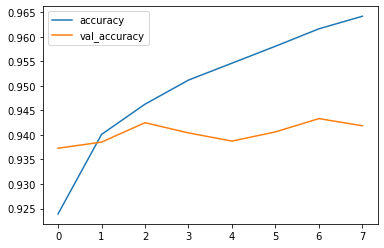

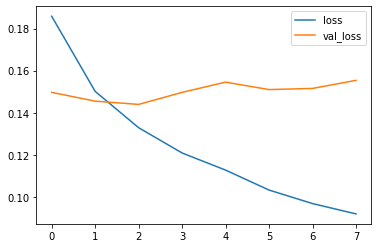

16/16 [==============================] - 3s 178ms/step - loss: 0.1491 - accuracy: 0.9490
Accuracy 0.9490000009536743
16/16 [==============================] - 5s 161ms/step


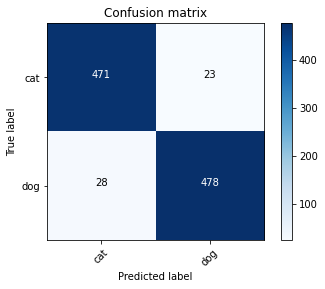

              precision    recall  f1-score   support

         Cat       0.94      0.95      0.95       494
         Dog       0.95      0.94      0.95       506

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



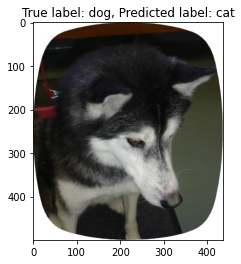

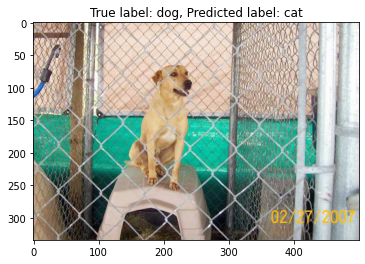

In [70]:
plot_learning_curve(model5_history)

loss, acc = model5.evaluate(test_data)
print("Accuracy", acc)

probs = model5.predict(test_data)
y_pred = np.argmax(probs,axis=1)
y_true = test_data.classes

plot_confusion_matrix(y_true, y_pred, test_data)

plot_classification_report(y_true, y_pred)

plot_2_misclassified_objects(y_pred, y_true, test_data)

## Model 6

In [76]:
batch_size_2 = 64
img_size_2 = 224

base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(img_size_2, img_size_2, 3), classes=2)

for layer in base_model.layers:
        layer.trainable = False

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(3,3))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.4)(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dense(2, activation="softmax")(head_model)
model6 = Model(inputs=base_model.input, outputs=head_model)
model6.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [77]:
# dataframe iterators
train_generator_2 = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input)

valid_generator_2 = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input)

test_generator_2 = ImageDataGenerator()
        
train_data_2 = train_generator_2.flow_from_dataframe(
            train_df,set_all_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size_2, img_size_2),
            batch_size = batch_size_2,
            shuffle=True,
            class_mode = 'categorical')

valid_data_2 = valid_generator_2.flow_from_dataframe(
              valid_df, set_all_dir,
              x_col = 'filename',
              y_col = 'category',
              target_size = (img_size_2, img_size_2),
              batch_size = batch_size_2,
              shuffle=True,
              class_mode = 'categorical')


test_data_2 = test_generator_2.flow_from_dataframe(
             test_df, set_all_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size_2, img_size_2),
             batch_size = batch_size_2,
             class_mode = 'categorical',
             shuffle = False)


Found 19198 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [78]:
model6.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [early_stopping]
epoch = 15

model6_history = model6.fit(train_data_2, epochs = epoch,
                            validation_data=valid_data_2,
                            validation_steps=valid_images//batch_size_2,
                            steps_per_epoch=train_images//batch_size_2,
                            callbacks=callbacks)

Epoch 1/15
217/299 [====================>.........] - ETA: 1:03 - loss: 0.0721 - accuracy: 0.9752

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

299/299 [==============================] - 307s 987ms/step - loss: 0.0655 - accuracy: 0.9768 - val_loss: 0.0319 - val_accuracy: 0.9896
Epoch 2/15
299/299 [==============================] - 290s 969ms/step - loss: 0.0470 - accuracy: 0.9843 - val_loss: 0.0370 - val_accuracy: 0.9875
Epoch 3/15
299/299 [==============================] - 290s 969ms/step - loss: 0.0399 - accuracy: 0.9851 - val_loss: 0.0354 - val_accuracy: 0.9879
Epoch 4/15
299/299 [==============================] - 289s 968ms/step - loss: 0.0354 - accuracy: 0.9880 - val_loss: 0.0316 - val_accuracy: 0.9896
Epoch 5/15
299/299 [==============================] - 291s 973ms/step - loss: 0.0341 - accuracy: 0.9883 - val_loss: 0.0315 - val_accuracy: 0.9896
Epoch 6/15
299/299 [==============================] - 289s 967ms/step - loss: 0.0320 - accuracy: 0.9892 - val_loss: 0.0294 - val_accuracy: 0.9912
Epoch 7/15
299/299 [==============================] - 289s 967ms/step - loss: 0.0284 - accuracy: 0.9892 - val_loss: 0.0420 - val_accura

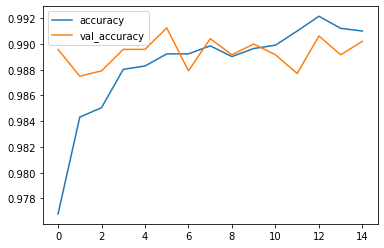

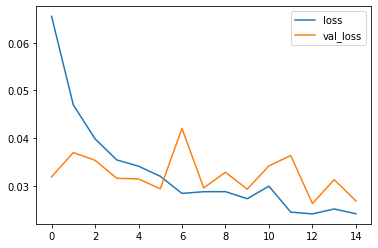

16/16 [==============================] - 3s 202ms/step - loss: 0.0061 - accuracy: 0.9960
Accuracy 0.9959999918937683
16/16 [==============================] - 6s 184ms/step


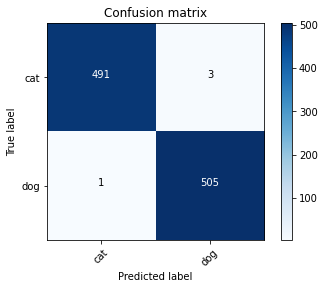

              precision    recall  f1-score   support

         Cat       1.00      0.99      1.00       494
         Dog       0.99      1.00      1.00       506

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



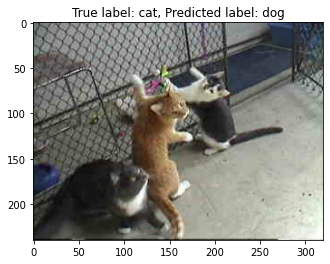

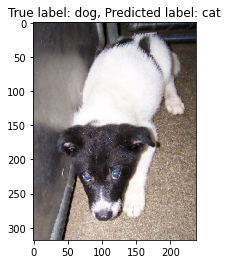

In [79]:
plot_learning_curve(model6_history)

loss, acc = model6.evaluate(test_data_2)
print("Accuracy", acc)

probs = model6.predict(test_data_2)
y_pred = np.argmax(probs,axis=1)
y_true = test_data_2.classes

plot_confusion_matrix(y_true, y_pred, test_data_2)

plot_classification_report(y_true, y_pred)

plot_2_misclassified_objects(y_pred, y_true, test_data_2)